In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [12]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open("/content/deu.txt", mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [13]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]
deu_eng

In [ ]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

In [58]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['it gave me the creeps', 'ich bekam davon gänsehaut',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #42354 (CK) & #2143533 (Tamy)'],
       ['it happened in boston', 'es ist in boston passiert',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6845115 (CK) & #7482756 (Luiaard)'],
       ['it happened last year', 'es passierte letztes jahr',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5751805 (Catriona) & #5751840 (wolfgangth)']],
      dtype='<U537')

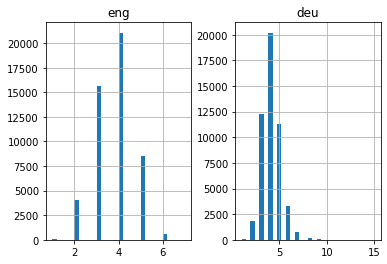

In [59]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [60]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [61]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6241


In [62]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10326


In [63]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [64]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [65]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [66]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [67]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [68]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 236s 4s/step - loss: 4.3649 - val_loss: 2.8249

Epoch 00001: val_loss improved from inf to 2.82491, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
63/63 [==============================] - 227s 4s/step - loss: 2.7880 - val_loss: 2.7618

Epoch 00002: val_loss improved from 2.82491 to 2.76185, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 3/30
63/63 [==============================] - 227s 4s/step - loss: 2.6307 - val_loss: 2.5462

Epoch 00003: val_loss improved from 2.76185 to 2.54622, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 4/30
63/63 [==============================] - 226s 4s/step - loss: 2.4362 - val_loss: 2.3948

Epoch 00004: val_loss improved from 2.54622 to 2.39482, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 5/30
63/63 [==============================] - 226s 4s/step - loss: 2.2865 - val_loss: 2.2965

Epoch 00005: val_loss improved from 2.39482 to 2.29649, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 6/30
63/63 [==============================] - 227s 4s/step - loss: 2.1449 - val_loss: 2.2171

Epoch 00006: val_loss improved from 2.29649 to 2.21715, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 7/30
63/63 [==============================] - 226s 4s/step - loss: 2.0261 - val_loss: 2.1315

Epoch 00007: val_loss improved from 2.21715 to 2.13147, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 8/30
63/63 [==============================] - 227s 4s/step - loss: 1.9102 - val_loss: 2.0205

Epoch 00008: val_loss improved from 2.13147 to 2.02055, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 9/30
63/63 [==============================] - 227s 4s/step - loss: 1.8021 - val_loss: 1.9598

Epoch 00009: val_loss improved from 2.02055 to 1.95983, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 10/30
63/63 [==============================] - 227s 4s/step - loss: 1.6944 - val_loss: 1.8822

Epoch 00010: val_loss improved from 1.95983 to 1.88221, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 11/30
63/63 [==============================] - 228s 4s/step - loss: 1.5987 - val_loss: 1.8186

Epoch 00011: val_loss improved from 1.88221 to 1.81855, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 12/30
63/63 [==============================] - 229s 4s/step - loss: 1.5016 - val_loss: 1.7712

Epoch 00012: val_loss improved from 1.81855 to 1.77125, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 13/30
63/63 [==============================] - 229s 4s/step - loss: 1.4103 - val_loss: 1.7151

Epoch 00013: val_loss improved from 1.77125 to 1.71512, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 14/30
63/63 [==============================] - 228s 4s/step - loss: 1.3207 - val_loss: 1.6563

Epoch 00014: val_loss improved from 1.71512 to 1.65634, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 15/30
63/63 [==============================] - 228s 4s/step - loss: 1.2373 - val_loss: 1.6431

Epoch 00015: val_loss improved from 1.65634 to 1.64310, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 16/30
63/63 [==============================] - 229s 4s/step - loss: 1.1574 - val_loss: 1.5690

Epoch 00016: val_loss improved from 1.64310 to 1.56899, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 17/30
63/63 [==============================] - 229s 4s/step - loss: 1.0704 - val_loss: 1.5286

Epoch 00017: val_loss improved from 1.56899 to 1.52863, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 18/30
63/63 [==============================] - 229s 4s/step - loss: 1.0043 - val_loss: 1.4967

Epoch 00018: val_loss improved from 1.52863 to 1.49671, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 19/30
63/63 [==============================] - 229s 4s/step - loss: 0.9346 - val_loss: 1.4693

Epoch 00019: val_loss improved from 1.49671 to 1.46933, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 20/30
63/63 [==============================] - 229s 4s/step - loss: 0.8751 - val_loss: 1.4442

Epoch 00020: val_loss improved from 1.46933 to 1.44420, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 21/30
63/63 [==============================] - 228s 4s/step - loss: 0.8104 - val_loss: 1.4217

Epoch 00021: val_loss improved from 1.44420 to 1.42174, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 22/30
63/63 [==============================] - 228s 4s/step - loss: 0.7431 - val_loss: 1.3832

Epoch 00022: val_loss improved from 1.42174 to 1.38316, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 23/30
63/63 [==============================] - 228s 4s/step - loss: 0.6944 - val_loss: 1.3827

Epoch 00023: val_loss improved from 1.38316 to 1.38270, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 24/30
63/63 [==============================] - 228s 4s/step - loss: 0.6417 - val_loss: 1.3521

Epoch 00024: val_loss improved from 1.38270 to 1.35213, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 25/30
63/63 [==============================] - 228s 4s/step - loss: 0.5868 - val_loss: 1.3479

Epoch 00025: val_loss improved from 1.35213 to 1.34795, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 26/30
63/63 [==============================] - 228s 4s/step - loss: 0.5388 - val_loss: 1.3400

Epoch 00026: val_loss improved from 1.34795 to 1.34001, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 27/30
63/63 [==============================] - 229s 4s/step - loss: 0.4923 - val_loss: 1.3309

Epoch 00027: val_loss improved from 1.34001 to 1.33088, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 28/30
63/63 [==============================] - 231s 4s/step - loss: 0.4485 - val_loss: 1.3226

Epoch 00028: val_loss improved from 1.33088 to 1.32258, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 29/30
63/63 [==============================] - 231s 4s/step - loss: 0.4177 - val_loss: 1.3070

Epoch 00029: val_loss improved from 1.32258 to 1.30695, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 30/30
63/63 [==============================] - 229s 4s/step - loss: 0.3804 - val_loss: 1.3021

Epoch 00030: val_loss improved from 1.30695 to 1.30209, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


In [2]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: ignored

In [1]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

NameError: ignored

In [49]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [50]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [51]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
499,i felt giddy,i am a
60,were tired,you me
686,toms amused,tom
23,tom can walk,tom was tom
264,freeze,no it
529,im sad now,im
582,wait up,its it
831,beers good,please
128,were afraid,you me
224,put it on,dont it
